In [1]:
%matplotlib inline
import cv2 as cv
import os 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import shutil
import random
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dropout, Dense
from keras.preprocessing import image as kimage
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.applications import mobilenet_v2
from keras.applications import vgg16
from keras.applications import resnet50

In [3]:
face_detector = cv.CascadeClassifier('haarcascade_frontalface_default.xml')

In [4]:
if not os.path.exists('./ImageRec'):
    os.makedirs('./ImageRec')

In [8]:
root_dir = './ImageRec'

In [6]:
os.listdir(root_dir)

In [7]:
def video_to_img(video_path, n_class):
    
    cam = cv.VideoCapture(video_path)
    
    if not os.path.exists('./ImageRec/' + n_class):
        os.makedirs('./ImageRec/' + n_class)
    
    currentname = len(os.listdir('./ImageRec/' + n_class))
    
    while(True): 
        
        ret,frame = cam.read() 
        if ret: 
            faces = face_detector.detectMultiScale(frame) 
            if len(faces) == 1:
                (x,y,w,h) = faces[0]
                face = frame[y:y+h, x:x+h,:]
                face=cv.resize(face, (224,224)) #lasciare o togliere?    
                name = './ImageRec/'+ n_class + '/frame' + str(currentname) + str(n_class) + '.jpg'
                print ('Creating...' + name) 
  
                cv.imwrite(name, face) 
  
            currentname += 1
        else: 
            break
  
    cam.release() 
    cv.destroyAllWindows() 
    
    

Video con i volti da riconoscere

In [8]:
video_to_img('videomarco1.mp4', 'classe1')

In [9]:
video_to_img('videomarco2.mp4', 'classe1')

In [10]:
video_to_img('roberto1.webm', 'classe2')

In [11]:
video_to_img('roberto2.webm', 'classe2')

In [12]:
video_to_img('uefa.webm', 'classe3') # inoltre sono state aggiunte alcune immagini successivamente

In [13]:
# funzione per aumentare casualmete la luminosità

def augment_brightness_camera_images(image):
    image1 = cv.cvtColor(image,cv.COLOR_RGB2HSV)
    random_bright = 0.25+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv.cvtColor(image1,cv.COLOR_HSV2RGB)
    return image1

In [14]:
# funzione per creare le copie con diversa luminosità, aumentare range(x) per ottenere più copie

def image_augmentation(path):
    for foto in os.listdir(path):
        img = mpimg.imread(os.path.join(path, foto))
        for i in range(1):
            imgg = augment_brightness_camera_images(img)
            copia_foto = path + '/' + foto.rpartition('.jpg')[0] + 'copia' + str(i+1) + '.jpg'
            mpimg.imsave(copia_foto, imgg)
            print ('Creating...' + copia_foto ) 
    

In [15]:
# creo copie per ogni immagine
for subdir in os.listdir(root_dir):
    image_augmentation(os.path.join(root_dir, subdir))

In [63]:
classes = [name for name in os.listdir(root_dir)]

In [64]:
if not os.path.exists(root_dir +'/train'):
    os.makedirs(root_dir +'/train')
if not os.path.exists(root_dir +'/test'):    
    os.makedirs(root_dir +'/test')

In [65]:
# divisione train e test
for cls in classes:
    
    if not os.path.exists(root_dir +'/train/' + cls):
        os.makedirs(root_dir +'/train/' + cls)
    if not os.path.exists(root_dir +'/test/' + cls):     
        os.makedirs(root_dir +'/test/' + cls)
    
    src = root_dir + '/' + cls 

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)*(0.8))])

    
    
    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

    print('Total images: ', len(allFileNames))
    print('Training: ', len(train_FileNames))
    print('Testing: ', len(test_FileNames))

   
    for name in train_FileNames:
        shutil.copy(name, root_dir +'/train/' + cls)

    for name in test_FileNames:
        shutil.copy(name, root_dir +'/test/' + cls)

Total images:  1027
Training:  821
Testing:  206
Total images:  1212
Training:  969
Testing:  243
Total images:  678
Training:  542
Testing:  136


In [4]:
#rete preaddestrata
vgg = vgg16.VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False, pooling='avg')

58892288/58889256 [==============================] - 14s 0us/step


In [9]:
train_preprocessing = kimage.ImageDataGenerator(preprocessing_function=vgg16.preprocess_input, 
                                     horizontal_flip=True,         
                                     width_shift_range=0.2,        
                                     height_shift_range=0.2,       
                                     zoom_range = [0.5,1.0],       
                                     rotation_range=90
                                     )

In [12]:
train_generator = train_preprocessing.flow_from_directory(
    directory='./ImageRec/train',
    target_size=(224,224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=1
    )


Found 2332 images belonging to 3 classes.


In [13]:
test_preprocessing = kimage.ImageDataGenerator(preprocessing_function=vgg16.preprocess_input)

In [14]:
test_generator = test_preprocessing.flow_from_directory(
    directory='./ImageRec/test',
    target_size=(224,224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=True, #per la confusion matrix lo imposto a false
    seed=1
    )

Found 585 images belonging to 3 classes.


In [15]:
for layer in vgg.layers:
    layer.trainable = False

In [19]:
x = vgg.output
x = Dense(512,activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.15)(x)
pred = Dense(3, activation='softmax')(x) 

net = Model(vgg.input, pred)

In [20]:
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=Adam(),
            metrics=['accuracy'])

In [74]:
epochs = 10
steps_per_epoch = 10

early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=3,
    mode='max',
    restore_best_weights=True)

In [75]:
results = net.fit_generator(
    train_generator,
    epochs=epochs, steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    callbacks = [early_stopping]
    )

Epoch 1/10
10/10 [==============================] - 210s 21s/step - loss: 0.9102 - accuracy: 0.7688 - val_loss: 0.4740 - val_accuracy: 0.5897
Epoch 2/10
10/10 [==============================] - 219s 22s/step - loss: 0.2781 - accuracy: 0.9250 - val_loss: 0.0026 - val_accuracy: 0.9179
Epoch 3/10
10/10 [==============================] - 214s 21s/step - loss: 0.1111 - accuracy: 0.9684 - val_loss: 0.5703 - val_accuracy: 0.7385
Epoch 4/10
10/10 [==============================] - 220s 22s/step - loss: 0.1269 - accuracy: 0.9688 - val_loss: 0.0237 - val_accuracy: 0.9795
Epoch 5/10
10/10 [==============================] - 222s 22s/step - loss: 0.1096 - accuracy: 0.9625 - val_loss: 0.0094 - val_accuracy: 0.9846
Epoch 6/10
10/10 [==============================] - 237s 24s/step - loss: 0.0480 - accuracy: 0.9781 - val_loss: 0.0450 - val_accuracy: 0.9368
Epoch 7/10
10/10 [==============================] - 237s 24s/step - loss: 0.0878 - accuracy: 0.9812 - val_loss: 0.0232 - val_accuracy: 0.9863
Epoch 

In [133]:
#net.save('retevgg3.h5')

In [13]:
y_true = test_generator.classes

In [14]:
probabilities = net.predict_generator(generator=test_generator)

In [15]:
y_predetti = np.argmax(probabilities, axis=1)

In [16]:
print('Confusion Matrix')
cm = confusion_matrix(y_true, y_predetti)
print(cm)
print('Classification Report')
target_names = ['Marco', 'Roberto', 'Sconosciuto']
print(classification_report(y_true, y_predetti, target_names=target_names))

Confusion Matrix
[[206   0   0]
 [  0 242   1]
 [  3   4 129]]
Classification Report
              precision    recall  f1-score   support

       Marco       0.99      1.00      0.99       206
     Roberto       0.98      1.00      0.99       243
 Sconosciuto       0.99      0.95      0.97       136

    accuracy                           0.99       585
   macro avg       0.99      0.98      0.98       585
weighted avg       0.99      0.99      0.99       585



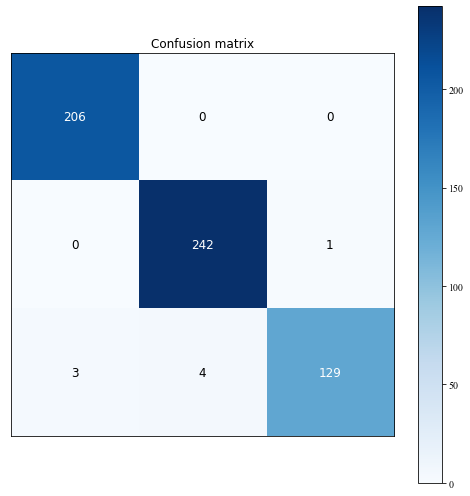

In [119]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=[], yticks = [])
plt.title('Confusion matrix', fontname='Helvetica')
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j]), size='large', fontname='Helvetica',
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

In [76]:
plt.rcParams['figure.figsize'] = (18, 12)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
    metrics =  ['loss', 'accuracy']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color=colors[0], linestyle="--", label='Test')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'accuracy':
            plt.ylim([0.2,1])
        else:
            plt.ylim([0,1])

        plt.legend()

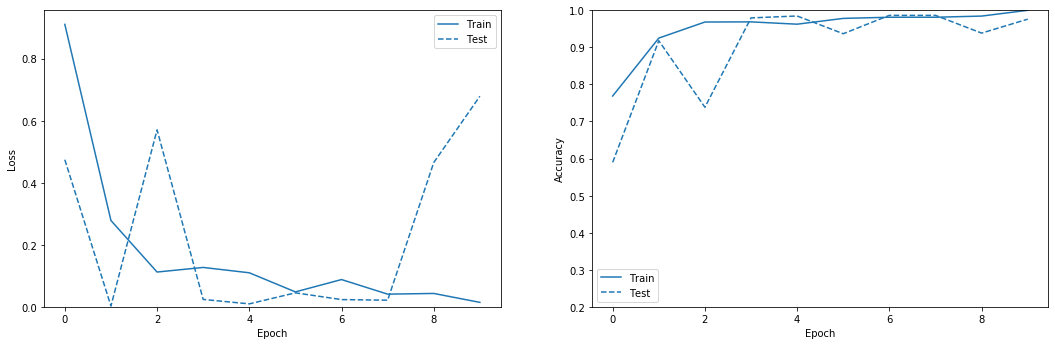

In [77]:
plot_metrics(results)

In [126]:
net = keras.models.load_model('retevgg3.h5')

In [123]:
names = ['Marco', 'Roberto', '???']

Prova con foto scattata da webcam

In [29]:
cap = cv.VideoCapture(0)
# Acquisizione immagine
result, img = cap.read()
# Rilascio del dispositivo
cap.release()

In [30]:
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
faces = face_detector.detectMultiScale(img_gray)
print(len(faces))
for (x,y,w,h) in faces:
        face = img[y:y+h,x:x+h,:]

1


In [120]:
plt.imshow(face[:,:,-1::-1]), plt.show()

In [32]:
img_pixels = cv.resize(face, (224, 224)) 
img_pixels = kimage.img_to_array(img_pixels)
img_pixels = np.expand_dims(img_pixels, axis = 0)
img_pixels = vgg16.preprocess_input(img_pixels)
y_pred = net.predict(img_pixels)
y_pred_name = np.argmax(y_pred)
names[y_pred_name]

'Marco'

Prova con foto caricata

In [34]:
img = mpimg.imread('marco.jpg')

1


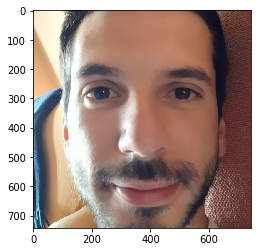

In [35]:
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
faces = face_detector.detectMultiScale(img_gray)
print(len(faces))
for (x,y,w,h) in faces:
        face = img[y:y+h,x:x+h,:]
        
plt.imshow(face); plt.show()        

In [36]:
img_pixels = cv.resize(face, (224, 224)) 
img_pixels = kimage.img_to_array(img_pixels)
img_pixels = np.expand_dims(img_pixels, axis = 0)
img_pixels = vgg16.preprocess_input(img_pixels)
y_pred = net.predict(img_pixels)
y_pred_name = np.argmax(y_pred)
names[y_pred_name]

'Marco'

Prova con video da webcam

In [124]:
def process_frame(img):
    if img is not None:
        img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        faces = face_detector.detectMultiScale(img_gray)
        if len(faces)>=1:
            (x,y,w,h) = faces[0]
            face = img[y:y+h, x:x+h, :]
            img_pixels = cv.resize(face, (224, 224)) 
            img_pixels = kimage.img_to_array(img_pixels)
            img_pixels = np.expand_dims(img_pixels, axis = 0)
            img_pixels = vgg16.preprocess_input(img_pixels)
            y_pred = net.predict(img_pixels)
            y_pred_name = np.argmax(y_pred)
            testo = names[y_pred_name] # + ' ' + str(int(np.max(y_pred)* 100))+'%'
            
            cv.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
            cv.putText(img, testo, org = (200, 230), fontScale = 1, fontFace = cv.FONT_HERSHEY_SIMPLEX, 
                       color = (0, 0, 255), thickness = 2)
    
    return img 

In [127]:
cap = cv.VideoCapture(0)
while(True): 
    # Acquisizione nuovo frame
    r, frame = cap.read() 
    # Elaborazione del contenuto
    frame = process_frame(frame) 

    cv.imshow('Video', frame) 
    # Interruzione alla pressione del tasto Q
    if cv.waitKey(20) & 0xFF == ord('q'):
        break
cap.release() 
cv.destroyAllWindows() 